In [32]:
# import dependencies
import io
import re
import nltk
import json
import gzip
import torch
import spacy
import string
import jsonlines
import pandas as pd
import pickle as pkl
import numpy as np
import mwparserfromhell
from torch.utils.data import Dataset
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm, tqdm_notebook

from spacy.lang.ru import Russian

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
PATH_TO_FOLDER = "/scratch/mz2476/"

## Load the data, preprocess, save to pkl

In [6]:
# Load Russian tokenizer, tagger, parser, NER and word vectors
tokenizer = Russian()
punctuations = string.punctuation

# set file names for dumping pickle files and input data source
FILE_NAME = PATH_TO_FOLDER + "wikitext_ru_sample.json"

PRETRAINED_EMBEDDINGS = PATH_TO_FOLDER + 'wiki.ru.align.vec'

TEXT_OUTPUT_FILE = '../../tokenized-data/wikitext_ru_tokenized.p'
SECTION_OUTPUT_FILE = '../../tokenized-data/wikisection_ru_tokenized.p'

MAX_ARTICLE_LENGTH = 500

# downloading and setting stop word list from NLTK
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /home/mz2476/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import rus_data_processing
from importlib import reload
reload(rus_data_processing)

[nltk_data] Downloading package stopwords to /home/mz2476/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'rus_data_processing' from '/home/mz2476/topic-modeling/topic-modeling/baseline/rus_data_processing.py'>

In [16]:
# #save the Wiki SECTION dataset in pickle file for subsequent use
# wiki_df = rus_data_processing.get_wiki_tokenized_dataset(FILE_NAME, True)
# pkl.dump(wiki_df, open(SECTION_OUTPUT_FILE, "wb"))

In [17]:
# #save the Wiki TEXT dataset in pickle file for subsequent use
# # Download the pickle files from Google Drive (else creating new will take ~4 hours)
# # https://drive.google.com/open?id=1DlNxxNh6WA5ds7px844LnBbhEzV0Ydyo
# wiki_df = rus_data_processing.get_wiki_tokenized_dataset(FILE_NAME)
# pkl.dump(wiki_df, open(TEXT_OUTPUT_FILE, "wb"))

In [8]:
# load the dataframe from pickle file - Wiki Text
wiki_df =  pkl.load(open(TEXT_OUTPUT_FILE, "rb"))

# load the dataframe from pickle file - Wiki Sections
#wiki_df =  pkl.load(open(SECTION_OUTPUT_FILE, "rb"))

In [9]:
wiki_df.head()

,QID,mid_level_categories,tokens
0,Q515,[],"[файл, два, ноль, один, один, токио, япония, ф..."
1,Q415638,[STEM.Chemistry],"[нитри, тита, на, бинарные, соединения, бинарн..."
2,Q333936,[STEM.Chemistry],"[файл, один, нитрилы, нитри, лы, органические,..."
3,Q7016,"[STEM.Time, History_And_Society.History and so...","[файл, три, века, один, семь, век, сытин, один..."
4,Q2622089,[STEM.Chemistry],"[файл, памятник, на, территории, словацкого, т..."


In [10]:
print(f"{wiki_df.shape[0]} articles in total.")

14787 articles in total.


## Explore the data

In [22]:
wiki_df['tokens'] = wiki_df['tokens'].apply(rus_data_processing.remove_short_words)
wiki_df['tokens'] = wiki_df['tokens'].apply(rus_data_processing.remove_stop_words)

Count distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ad88518de90>]],
      dtype=object)

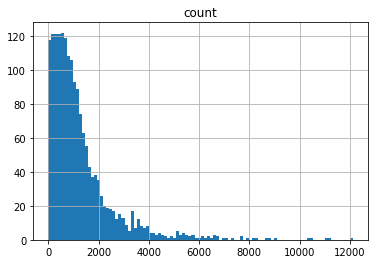

In [29]:
b = wiki_df['tokens'].apply(lambda x: len(x))
count_df = b.value_counts().sort_index().rename_axis('count').reset_index(name='frequency')
count_df.hist(column='count',bins=100)

Unique words in pretrained embeddings.

In [30]:
# load pre-trained fastText embeddings
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:]))).astype('float32')
    return data

pretrained_embs = load_vectors(PRETRAINED_EMBEDDINGS)

In [32]:
# get all unique tokens in the training dataset
all_train_tokens = []

for tokens in wiki_df['tokens']:
    for token in tokens:
        all_train_tokens.append(token)
        
all_train_tokens = list(set(all_train_tokens))

# Analyse the wiki tokens and fastText embeddings
train_token_count = len(all_train_tokens)
token_in_fasttext = []
token_not_in_fasttext = []
train_token_in_fasttxt = 0

for token in all_train_tokens:
    if token in pretrained_embs.keys():
        token_in_fasttext.append(token)
        train_token_in_fasttxt = train_token_in_fasttxt + 1
    else:
        token_not_in_fasttext.append(token)
        
print("% of unique Wiki tokens in fastText : {:4.2f}%".format(train_token_in_fasttxt/train_token_count*100))
print('unique tokens not in fastText :', len(token_not_in_fasttext))
print('unique tokens in fastText :', len(token_in_fasttext))

% of unique Wiki tokens in fastText : 85.17%
unique tokens not in fastText : 56317
unique tokens in fastText : 323331


In [33]:
print("Sample tokens not in the fastText")
token_not_in_fasttext[:10]

Sample tokens not in the fastText


['дилеммах',
 'фраиццоли',
 'прементора',
 'тэйяб',
 'гиддха',
 'рапаттони',
 'мазохом',
 'пьяджиа',
 'миусах',
 'брахмавид']

## Use pretrained baseline model

### Preprocess the data

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [17]:
import preprocess
import importlib
importlib.reload(preprocess)

from preprocess import remove_stop_words, train_validate_test_split
from preprocess import tokenize_dataset, TensoredDataset, pad_collate_fn

from functools import partial

[nltk_data] Downloading package stopwords to /home/mz2476/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
#Removing stop words
wiki_df['tokens'] = wiki_df["tokens"].apply(partial(remove_stop_words, language="russian"))
wiki_df.head()

#Removing rows with missing labels
mask = wiki_df.mid_level_categories.apply(lambda x: len(x) > 0)
wiki_df = wiki_df[mask]
wiki_df = wiki_df.reset_index(drop=True)
print(wiki_df.shape)

#Removing rows with no tokens
mask = wiki_df.tokens.apply(lambda x: len(x) > 0)
wiki_df = wiki_df[mask]
wiki_df = wiki_df.reset_index(drop=True)
print(wiki_df.shape)

(14439, 3)
(14438, 3)


In [19]:
# Binarize the labels
# labels list: mlb.classes_
mlb = MultiLabelBinarizer()
wiki_df["labels"] = list(mlb.fit_transform(wiki_df.mid_level_categories))
wiki_df.head()

,QID,mid_level_categories,tokens,labels
0,Q415638,[STEM.Chemistry],"[нитри, тита, бинарные, соединения, бинарное, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Q333936,[STEM.Chemistry],"[файл, нитрилы, нитри, лы, органические, соеди...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Q7016,"[STEM.Time, History_And_Society.History and so...","[файл, века, семь, век, сытин, девять, век, за...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Q2622089,[STEM.Chemistry],"[файл, памятник, территории, словацкого, техно...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Q43440,"[Culture.People, Culture.Language and literatu...","[джозуэ, карду, ччи, семь, июля, восемь, пять,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."


In [20]:
# train/val/test split
wiki_train, wiki_valid, wiki_test = train_validate_test_split(wiki_df, seed=1)

wiki_train = wiki_train.reset_index(drop=True)
wiki_valid = wiki_valid.reset_index(drop=True)
wiki_test = wiki_test.reset_index(drop=True)

In [21]:
# Building vocabulary
vocab = list(set([y for x in list(wiki_train['tokens']) for y in x]))

print("Vocab size is: {}".format(len(vocab)))

word_to_index = {"<pad>":0, "<unk>":1}
for word in vocab:
    if word not in word_to_index:
        word_to_index[word] = len(word_to_index)
index_to_word = {v:k for k, v in word_to_index.items()}

Vocab size is: 332286


In [24]:
word_to_index["мышь"]

243516

In [25]:
wiki_tokenized_train = tokenize_dataset(wiki_train, word_to_index)
wiki_tokenized_val = tokenize_dataset(wiki_valid, word_to_index)
wiki_tokenized_test = tokenize_dataset(wiki_test, word_to_index)

100%|██████████| 1445/1445 [00:00<00:00, 5319.92it/s]


In [26]:
wiki_tokenized_datasets = {}
wiki_tokenized_datasets['X_train'] = wiki_tokenized_train
wiki_tokenized_datasets['X_val'] = wiki_tokenized_val
wiki_tokenized_datasets['X_test'] = wiki_tokenized_test

wiki_tokenized_datasets['y_train'] = list(wiki_train.labels)
wiki_tokenized_datasets['y_val'] = list(wiki_valid.labels)
wiki_tokenized_datasets['y_test'] = list(wiki_test.labels)

wiki_tensor_dataset = {}
wiki_tensor_dataset['train'] = TensoredDataset(
    wiki_tokenized_datasets['X_train'], wiki_tokenized_datasets['y_train']
)
wiki_tensor_dataset['val'] = TensoredDataset(
    wiki_tokenized_datasets['X_val'], wiki_tokenized_datasets['y_val']
)
wiki_tensor_dataset['test'] = TensoredDataset(
    wiki_tokenized_datasets['X_test'], wiki_tokenized_datasets['y_test']
)

In [27]:
wiki_tensor_dataset["train"].__getitem__(200)

(tensor([328770, 239804, 102415, 325113, 158786, 220977, 328030,  43325, 221888,
         127505,  98824,  96066, 140931,  97442, 220823, 257025,  30344,  10292,
         154233, 154233, 135475, 103867, 254246,  67001,  99975, 207493, 260339,
         226821,  21905, 254618, 328770,  37987,  39043, 236966,  44727, 273113,
         310671, 290354, 290354, 310671, 245919, 116975,  74613, 306608, 100693,
         213306, 229436, 229436,  21514, 328770,  91248, 328770, 239804, 102415,
         253144, 280790, 154233, 154233, 135475,  67370, 253144,  44639, 280790,
         253144, 280790, 181887, 253144, 278368, 165038, 177782]),
 tensor([70.]),
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [30]:
# create dataloader
wiki_loaders = {}

batch_size = 32

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(
        wiki_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, word_to_index=word_to_index)
    )

### Load aligned Russian embeddings

In [33]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/mz2476/topic-modeling/topic-modeling/baseline/utils.py'>

In [34]:
# 2.5 million
embeddings = utils.load_vectors(PATH_TO_FOLDER + "wiki.ru.align.vec")

1888423it [02:27, 12814.64it/s]


In [35]:
#Creating the weight matrix for pretrained word embeddings
vocab_size = len(index_to_word)
embed_dim = len(embeddings["apple"])
weights_matrix = np.zeros((vocab_size,embed_dim))

words_found = 0
for i, word in enumerate(word_to_index):
    if word in embeddings.keys():
        weights_matrix[i] = embeddings[word]
        words_found += 1
    else:
        weights_matrix[i] = np.zeros(embed_dim)
weights_matrix = torch.FloatTensor(weights_matrix)

print("Total words in vocab: {}".format(len(vocab)))
print("No. of words from vocab found in fastText: {}".format(words_found))

Total words in vocab: 332286
No. of words from vocab found in fastText: 287017


### Model

In [36]:
import model
import importlib
importlib.reload(model)

from model import FinalModel
from torchcontrib.optim import SWA

In [ ]:
options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix.shape[1],
    "pretrained_embeddings": weights_matrix,
    "num_layers": 2,
    "num_classes": len(mlb.classes_),
    "mid_features": 100,
    "dropout_rate": 0.2,
    "activation": nn.ReLU()
}
model = FinalModel(options)

if torch.cuda.is_available():
    model = model.to(device)
    
# Criterion and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
base_opt = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = SWA(base_opt)